# (Discrete) [Rainbow](https://arxiv.org/pdf/1710.02298.pdf)

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque, Counter
import random
import gym
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

In [2]:
from solutions.memories import PrioritizedNStepMemory
from solutions.networks import NoisyDuelingNetwork
from solutions.agents import DQNAgent

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')
mem = PrioritizedNStepMemory(int(1e5))
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [64,64],
             action_size = env.action_space.n, replay_memory = mem,
             double=True, Architecture=NoisyDuelingNetwork) 

In [3]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=200
action_df = []
weight_df = []

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    actions = []
    while True:
        t+=1
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motivate your agent even more
        if done: 
            fake_reward = reward 
        else:
            fake_reward = reward
        
        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    action_df.append(Counter(actions))
    weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

W0826 09:19:17.643987 140736263197568 deprecation.py:323] From /Users/admin/.virtualenvs/sandbox/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episdoe 99 Moving Average: 96.97979797979798
Solved at Play 168: 0:06:28.600850 Moving average: 201.22


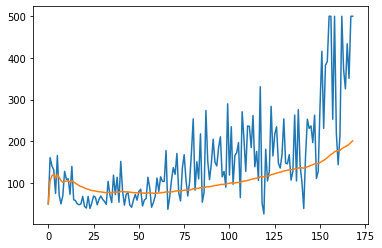

In [9]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

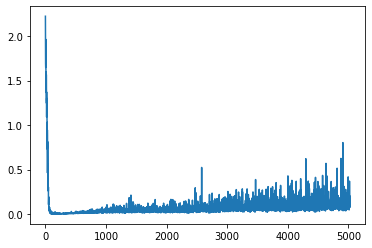

In [10]:
plt.plot(a.losses)

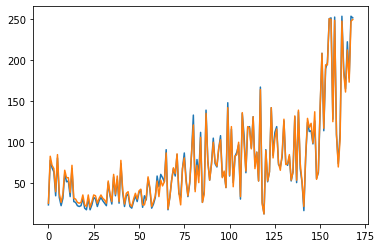

In [11]:
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

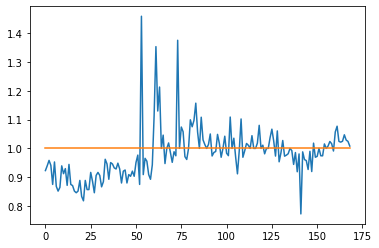

In [12]:
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

W0826 09:37:38.058408 140736263197568 legend.py:1282] No handles with labels found to put in legend.


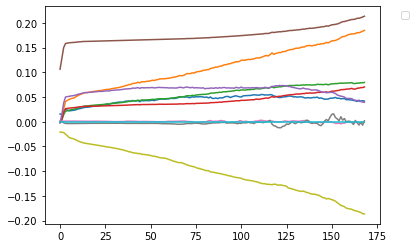

In [13]:
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)